In [1]:
import pandas as pd
import time
from datetime import datetime
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

### __Загрузим данные полученые из GoogleCloud.__

In [2]:
# загружаем данные выгруженные из googlecloud (в данные есть все/предположительно активности по event_name содержащие puzzle_id)
data=pd.read_csv('bq-results-20220427-160742-1651075923648.csv')
data.head()

,event_timestamp,event_name,user_id,puzzle_id,difficulty,category,days_in_game,mobile_brand_name,platform,continent,sub_continent,country
0,1646594561680038,game_puzzle_complete,b1d0d288c00ba434466b3406e2dbfc4f,14,49.0,37,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey
1,1646594969830071,game_puzzle_complete,b1d0d288c00ba434466b3406e2dbfc4f,42,49.0,15,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey
2,1646594992073092,game_puzzle_start,b1d0d288c00ba434466b3406e2dbfc4f,9,49.0,1,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey
3,1646594585806059,game_puzzle_start,b1d0d288c00ba434466b3406e2dbfc4f,42,49.0,15,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey
4,1646595512287123,game_puzzle_start,b1d0d288c00ba434466b3406e2dbfc4f,24,49.0,1,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey


In [3]:
# переведем timestamp  в datetime и уберем дубликаты
data['event_timestamp']=data['event_timestamp'].astype(str)
data['date_time']=list(map(lambda x : datetime.fromtimestamp(int(x[0:10])), data.event_timestamp))
data.drop('event_timestamp', axis=1,  inplace=True)
# не очень разобрался почему, но есть дубликаты, удлим их
data.drop_duplicates(inplace=True)
data.head()


,event_name,user_id,puzzle_id,difficulty,category,days_in_game,mobile_brand_name,platform,continent,sub_continent,country,date_time
0,game_puzzle_complete,b1d0d288c00ba434466b3406e2dbfc4f,14,49.0,37,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey,2022-03-06 22:22:41
1,game_puzzle_complete,b1d0d288c00ba434466b3406e2dbfc4f,42,49.0,15,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey,2022-03-06 22:29:29
2,game_puzzle_start,b1d0d288c00ba434466b3406e2dbfc4f,9,49.0,1,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey,2022-03-06 22:29:52
3,game_puzzle_start,b1d0d288c00ba434466b3406e2dbfc4f,42,49.0,15,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey,2022-03-06 22:23:05
4,game_puzzle_start,b1d0d288c00ba434466b3406e2dbfc4f,24,49.0,1,30,Xiaomi,ANDROID,Asia,Western Asia,Turkey,2022-03-06 22:38:32


In [4]:
print('Записей в датасете: ',data.shape[0])
print('Количество уникальных пользователей:', data.user_id.value_counts().count())
print('Диапазон дат: от ', data.date_time.min(), 'до ', data.date_time.max())
print('Категорий пазлов:', data.category.value_counts().count())
print('Пазлов всего:', data.puzzle_id.value_counts().count())



Записей в датасете:  109321
Количество уникальных пользователей: 6048
Диапазон дат: от  2022-03-02 00:01:24 до  2022-03-31 23:19:02
Категорий пазлов: 30
Пазлов всего: 100


<AxesSubplot:>

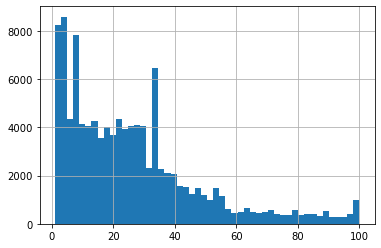

In [21]:
# гистограмма распределения puzzle_id
data['puzzle_id'].hist(bins=50)

<AxesSubplot:>

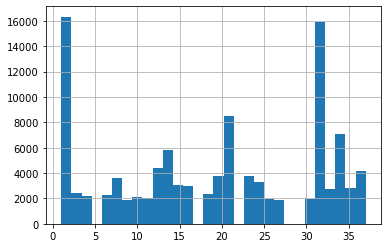

In [22]:
# гистограмма распределения category
data['category'].hist(bins=30)

### __Пример активности по game_puzzle_start одного user_id. Обращаем внимание на то, что есть перемещение между континентами.__  
Можно предположить возможность классификации пользователей по признаку/качеству перемещения на 'Местный', 'Экспат', 'Путешественник', хотя именно с этим пользоватедлем странная история - он с разницей в 21 минуту присутсвовал и в Африке и в Америке.

In [7]:
# пример активности 1 user_id по "game_puzzle_start"
data[data['user_id']=='09c3d5824c2dff1be81dd26fc199b66a'].query('difficulty>0 and event_name=="game_puzzle_start" ').sort_values('date_time')

,event_name,user_id,puzzle_id,difficulty,category,days_in_game,mobile_brand_name,platform,continent,sub_continent,country,date_time
65447,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,28,36.0,11,0,Infinix,ANDROID,Americas,Northern America,United States,2022-03-18 17:23:36
65196,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,33,36.0,1,0,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-18 17:44:32
65204,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,3,36.0,21,0,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-18 21:03:56
94895,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,55,36.0,34,0,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 09:44:47
94899,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,28,49.0,11,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 18:40:27
94903,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,20,49.0,18,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 19:59:25
40445,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,8,36.0,31,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 21:24:43
40451,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,1,36.0,34,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 21:33:50
40452,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,10,36.0,12,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 21:43:38
114447,game_puzzle_start,09c3d5824c2dff1be81dd26fc199b66a,9,36.0,25,2,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-20 20:03:39


### __Активность того же user_id по game_puzzle_complete.__  
Наблюдаем, что не все пазлы из начатых завершены. Можно допустить/предположить, что завершенные пазлы оказались более привлекательны/интересны для пользователя.

In [8]:
# пример активности 1 user_id по "game_puzzle_complete"
data[data['user_id']=='09c3d5824c2dff1be81dd26fc199b66a'].query('difficulty>0 and event_name=="game_puzzle_complete" ').sort_values('date_time')

,event_name,user_id,puzzle_id,difficulty,category,days_in_game,mobile_brand_name,platform,continent,sub_continent,country,date_time
65448,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,28,36.0,11,0,Infinix,ANDROID,Americas,Northern America,United States,2022-03-18 17:43:15
65202,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,33,36.0,1,0,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-18 21:03:08
94893,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,3,36.0,21,0,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 09:43:52
94902,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,28,49.0,11,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 19:58:30
40449,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,8,36.0,31,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 21:33:02
40444,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,1,36.0,34,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 21:42:59
40443,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,10,36.0,12,1,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-19 21:57:35
114448,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,9,36.0,25,2,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-20 20:20:42
114467,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,25,49.0,35,2,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-20 21:47:19
55491,game_puzzle_complete,09c3d5824c2dff1be81dd26fc199b66a,53,36.0,21,0,Infinix,ANDROID,Africa,Eastern Africa,Ethiopia,2022-03-25 20:39:13


### __Сформируем подзапросы, для удобства восприятия.__

In [9]:
# топ пазлов среди ВСЕХ, по континентам
top_puzzle=data[['puzzle_id', 'user_id', 'continent']].groupby(by=['puzzle_id', 'continent']).count().sort_values('user_id', ascending=False)
top_puzzle.rename(columns={'user_id':'count_user_id'}, inplace=True)
top_puzzle.reset_index(inplace=True)
top_puzzle.head()

,puzzle_id,continent,count_user_id
0,3,Africa,2215
1,1,Africa,2170
2,8,Africa,2054
3,33,Africa,1886
4,3,Americas,1806


In [10]:
# топ категорий среди ВСЕХ, по континентам
top_category=data[[ 'user_id', 'category', 'continent']].groupby(by=['category', 'continent']).count().sort_values('user_id', ascending=False)
top_category.rename(columns={'user_id':'count_user_id'}, inplace=True)
top_category.reset_index(inplace=True)
top_category.head()

,category,continent,count_user_id
0,1,Africa,4204
1,31,Africa,4152
2,1,Americas,3875
3,31,Europe,3549
4,1,Europe,3475


In [11]:
# топ пазлов среди GAME_PUZZLE_START, по континентам
top_puzzle_start=data[['event_name','puzzle_id', 'user_id', 'continent']].query('event_name=="game_puzzle_start"').groupby(by=['puzzle_id', 'continent', 'event_name']).count().sort_values('user_id', ascending=False)
top_puzzle_start.rename(columns={'user_id':'count_user_id'}, inplace=True)
top_puzzle_start.reset_index(inplace=True)
top_puzzle_start.head()

,puzzle_id,continent,event_name,count_user_id
0,1,Africa,game_puzzle_start,558
1,3,Africa,game_puzzle_start,554
2,8,Africa,game_puzzle_start,513
3,3,Americas,game_puzzle_start,479
4,33,Africa,game_puzzle_start,459


In [12]:
# топ категорий среди GAME_PUZZLE_START, по континентам
top_category_start=data[['event_name','user_id', 'category', 'continent']].query('event_name=="game_puzzle_start"').groupby(by=['category', 'continent', 'event_name']).count().sort_values('user_id', ascending=False)
top_category_start.rename(columns={'user_id':'count_user_id'}, inplace=True)
top_category_start.reset_index(inplace=True)
top_category_start.head()

,category,continent,event_name,count_user_id
0,31,Europe,game_puzzle_start,1117
1,1,Americas,game_puzzle_start,1108
2,1,Europe,game_puzzle_start,1089
3,31,Africa,game_puzzle_start,1086
4,1,Africa,game_puzzle_start,1084


In [13]:
# топ пазлов среди GAME_PUZZLE_COMPLETE, по континентам
top_puzzle_complete=data[['event_name','puzzle_id', 'user_id', 'continent']].query('event_name=="game_puzzle_complete"').groupby(by=['puzzle_id', 'continent', 'event_name']).count().sort_values('user_id', ascending=False)
top_puzzle_complete.rename(columns={'user_id':'count_user_id'}, inplace=True)
top_puzzle_complete.reset_index(inplace=True)
top_puzzle_complete.head()

,puzzle_id,continent,event_name,count_user_id
0,3,Africa,game_puzzle_complete,431
1,1,Africa,game_puzzle_complete,427
2,8,Africa,game_puzzle_complete,394
3,3,Americas,game_puzzle_complete,392
4,33,Africa,game_puzzle_complete,391


In [14]:
# топ категорий среди GAME_PUZZLE_COMPLETE, по континентам
top_category_complete=data[['event_name','user_id', 'category', 'continent']].query('event_name=="game_puzzle_complete"').groupby(by=['category', 'continent', 'event_name']).count().sort_values('user_id', ascending=False)
top_category_complete.rename(columns={'user_id':'count_user_id'}, inplace=True)
top_category_complete.reset_index(inplace=True)
top_category_complete.head()

,category,continent,event_name,count_user_id
0,31,Europe,game_puzzle_complete,1021
1,1,Americas,game_puzzle_complete,1019
2,1,Africa,game_puzzle_complete,962
3,1,Europe,game_puzzle_complete,957
4,31,Africa,game_puzzle_complete,874


### __Итого, имеем следующие таблицы__
top_puzzle - топ пазлов среди ВСЕХ, по континентам  
top_category - топ категорий среди ВСЕХ, по континентам  
top_puzzle_start - топ пазлов среди GAME_PUZZLE_START, по континентам  
top_category_start - топ категорий среди GAME_PUZZLE_START, по континентам  
top_puzzle_complete - топ пазлов среди GAME_PUZZLE_COMPLETE, по континентам  
top_category_complete - топ категорий среди GAME_PUZZLE_COMPLETE, по континентам  

### __1. Сформируем рекомендации, по разным критериям, для всех континентов.__

### __1.1. Рекомендация самых популярных (по всем event_name) пазлов, по континентам.__  
0 - самый популярный пазл, 1 - чуть менее и так далее...  
Обращаем внимание на то, что пазлы в ТОП-25 разных континентов во многом пересекаются/повторяются, но зачастую имеют разные ранги, кроме того есть уникальные/непересекающиеся пазлы.  
*По Oceania и (not set) данных значительно меньше чем для отсальных континентов.

In [15]:
final_recomendation_1=pd.DataFrame()
dict={0:'Africa', 1:'Americas', 2:'Europe', 3:'Asia', 4:'(not set)', 5:'Oceania'}
for i in range(len(top_puzzle.continent.value_counts())):
    temp=top_puzzle[top_puzzle['continent']==dict[i]].iloc[:,0]
    final_recomendation_1[dict[i]] = temp.reset_index(drop=True)
final_recomendation_1 = final_recomendation_1.fillna(99999).astype(int)
final_recomendation_1.head(25)

,Africa,Americas,Europe,Asia,(not set),Oceania
0,3,3,3,1,1,8
1,1,8,1,8,3,3
2,8,1,33,3,8,33
3,33,33,8,33,5,6
4,13,13,26,12,9,1
5,6,22,2,26,27,12
6,10,2,24,2,23,19
7,26,6,30,9,2,40
8,2,9,27,7,18,5
9,21,21,21,5,22,23


### __1.2. Рекомендация самых популярных (по всем event_name) категорий, по континентам.__  
0 - самыая популярная категория, 1 - чуть менее и так далее...  

In [24]:
final_recomendation_2=pd.DataFrame()
dict={0:'Africa', 1:'Americas', 2:'Europe', 3:'Asia', 4:'(not set)', 5:'Oceania'}
for i in range(len(top_category.continent.value_counts())):
    temp=top_category[top_category['continent']==dict[i]].iloc[:,0]
    final_recomendation_2[dict[i]] = temp.reset_index(drop=True)
final_recomendation_2 = final_recomendation_2.fillna(99999).astype(int)
final_recomendation_2.head(15)

,Africa,Americas,Europe,Asia,(not set),Oceania
0,1,1,31,1,31,1
1,31,31,1,31,1,31
2,21,21,21,34,21,7
3,34,34,34,21,34,21
4,12,23,13,12,7,34
5,7,12,23,24,37,3
6,35,7,12,35,24,13
7,16,24,32,15,20,15
8,15,13,15,37,12,10
9,33,16,7,18,33,23


### __1.3 Рекомендация самых популярных пазлов ИЗ ТЕХ, С КОТОРЫХ НАЧИНАЛИ (game_puzzle_start), по континентам.__  
0 - самый популярный пазл, 1 - чуть менее и так далее...  
Обращаем внимание на то, что пазлы в ТОП-25 разных континентов во многом пересекаются/повторяются, но зачастую имеют разные ранги, кроме того есть уникальные/непересекающиеся пазлы.  
*По Oceania и (not set) данных значительно меньше чем для отсальных континентов.__

In [17]:
final_recomendation_3=pd.DataFrame()
dict={0:'Africa', 1:'Americas', 2:'Europe', 3:'Asia', 4:'(not set)', 5:'Oceania'}
for i in range(len(top_puzzle_start.continent.value_counts())):
    temp=top_puzzle_start[top_puzzle_start['continent']==dict[i]].iloc[:,0]
    final_recomendation_3[dict[i]] = temp.reset_index(drop=True)
final_recomendation_3 = final_recomendation_3.fillna(99999).astype(int)
final_recomendation_3.head(25)

,Africa,Americas,Europe,Asia,(not set),Oceania
0,1,3,3,3,3,8
1,3,8,1,8,8,3
2,8,1,8,1,1,33
3,33,33,33,33,30,19
4,14,13,2,12,26,23
5,10,12,21,26,18,12
6,27,2,14,2,23,40
7,2,30,27,7,2,36
8,6,21,24,29,9,1
9,22,6,26,6,20,18


### __1.4. Рекомендация самых популярных пазлов ИЗ ТЕХ КОТОРЫЕ ЗАКОНЧИЛИ (game_puzzle_complete), по континентам.__  
0 - самый популярный пазл, 1 - чуть менее и так далее...  
Обращаем внимание на то, что пазлы в ТОП-25 разных континентов во многом пересекаются, но зачастую имеют разные ранги, кроме того есть уникальные/непересекающиеся пазлы.  
*По Oceania и (not set) данных значительно меньше чем для отсальных континентов.__

In [18]:
final_recomrndation4=pd.DataFrame()
dict={0:'Africa', 1:'Americas', 2:'Europe', 3:'Asia', 4:'(not set)', 5:'Oceania'}
for i in range(len(top_puzzle_complete.continent.value_counts())):
    temp=top_puzzle_complete[top_puzzle_complete['continent']==dict[i]].iloc[:,0]
    final_recomrndation4[dict[i]] = temp.reset_index(drop=True)
final_recomrndation4 = final_recomrndation4.fillna(99999).astype(int)
final_recomrndation4.head(25)


,Africa,Americas,Europe,Asia,(not set),Oceania
0,3,3,3,3,3,8
1,1,8,8,8,8,3
2,8,1,33,1,1,33
3,33,33,1,33,7,19
4,6,2,2,12,5,5
5,2,13,14,26,2,1
6,10,22,21,2,26,4
7,14,30,26,7,30,11
8,22,26,27,19,23,12
9,29,9,18,9,20,40


### __2. Проверим значимости различий показателй между континентами.__  
Воспользуемся Тестом хи-квадрат Пирсона.  Критерий хи-квадрат Пирсона – это непараметрический метод, который позволит нам оценить значимость различий между  количеством исходов или качественных характеристик выборки одного континента/выборки, попадающих в каждую категорию, и количеством другого континета/выборки, при справедливости нулевой гипотезы. Иначе говоря Критерий хи-квадрат Пирсона проверяет значимость расхождения одних наблюдаемых частот и других наблюдаемых частот.


### __2.1. Оценим значимость различий среди (по всем event_name) категорий, для примера, в Americas и Europe.__   
Нулевая гипотеза (Н0) - частоты согласованы, разницы между наблюдениями нет.  
Альтернативная гипотеза (Н1) - отклонения в частотах выходят за рамки случайных колебаний и расхождения статистически значимы.  
Для наглядности приведем таблицу сопряженности

In [62]:
conjugacy_table=pd.DataFrame()
conjugacy_table['caregory'] = top_category[top_category['continent']=='Americas'].sort_values('category').reset_index(drop=True)['category']
conjugacy_table['Americas'] = top_category[top_category['continent']=='Americas'].sort_values('category').reset_index(drop=True)['count_user_id']
conjugacy_table['Europe'] = top_category[top_category['continent']=='Europe'].sort_values('category').reset_index(drop=True)['count_user_id']
conjugacy_table.T

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
caregory,1,2,3,4,6,7,9,10,11,12,...,25,27,30,31,32,33,34,35,36,37
Americas,3875,767,763,661,749,1242,517,670,560,1551,...,512,559,567,3290,676,933,1793,871,526,857
Europe,3475,474,472,519,435,673,420,515,383,845,...,405,472,460,3549,777,521,1520,582,277,601


In [64]:
table=[list(top_category[top_category['continent']=='Americas'].sort_values('category').reset_index(drop=True)['count_user_id']),\
     list(top_category[top_category['continent']=='Europe'].sort_values('category').reset_index(drop=True)['count_user_id'])]
chi2, prob, df, expected = chi2_contingency(table)
print('p-value: ', prob)    

p-value:  4.7638396480356694e-145


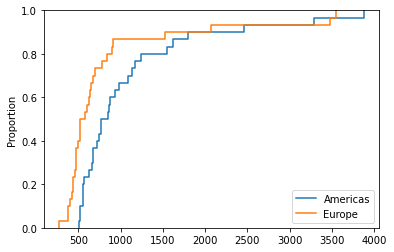

In [74]:
# эмпиричесская функция распределния вероятностей
ig, ax = plt.subplots()
sns.ecdfplot(x=table[0], ax=ax, label='Americas')
sns.ecdfplot(x=table[1], ax=ax, label='Europe')
ax.legend()

На уровне значимости 0.05 отвергаем нулевую гипотезу о том, что между грппами нет статистически значимых различий.  
__Группы наблюдений Americas и Europe  - имеют статистически значимые различия.__

### __2.1. Оценим значимость различий среди (event_name = puzzle_complete) пазлов, для примера, в Americas и Europe.__   
Нулевая гипотеза (Н0) - частоты согласованы, разницы между наблюдениями нет.  
Альтернативная гипотеза (Н1) - отклонения в частотах выходят за рамки случайных колебаний и расхождения статистически значимы.  
Для наглядности приведем таблицу сопряженности

In [108]:
table=[list(top_puzzle_complete[top_puzzle_complete['continent']=='Americas'].sort_values('puzzle_id').reset_index(drop=True)['count_user_id']),\
     list(top_puzzle_complete[top_puzzle_complete['continent']=='Europe'].sort_values('puzzle_id').reset_index(drop=True)['count_user_id'])]
chi2, prob, df, expected = chi2_contingency(table)
print('p-value: ', prob)    

p-value:  0.003285659993974158


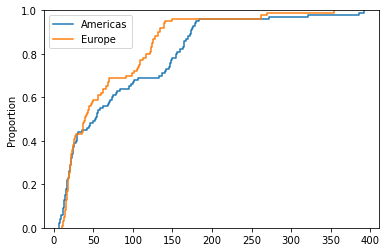

In [109]:
# эмпиричесская функция распределния вероятностей
ig, ax = plt.subplots()
sns.ecdfplot(x=table[0], ax=ax, label='Americas')
sns.ecdfplot(x=table[1], ax=ax, label='Europe')
ax.legend()

На уровне значимости 0.05 отвергаем нулевую гипотезу о том, что между грппами нет статистически значимых различий.  
__Группы наблюдений Americas и Europe  - имеют статистически значимые различия.__  
обращаем внимание на p-value  в случае сравнения категорий и p-value  в случае сравнения пазлов

### __3. Выводы.__  
1. Строить не сложныее ркомендации можно опираясь на частоты обращения пользователей к тем или иным пазлам и категориям.  
2. Можно говорить о том, что возможно наблюдение различий в поведении пользователей при рекомендации им пазлов из ТОП "общих", ТОП начатых и из ТОП законченных.  
3. Выявлены различия между ТОПами пазлов на разных континентах (причины различий пока не понятны, это могут быть и континентальные особанности и особенности предыдущих рекомендаций).  
4. Выстраивая обучаемую рекомендательную модель, было бы интересно более качественно дифференцировать рекомендации для разных континентов.
5. Есть смысл озадачиться вопросом классификации пользователей, даже с тем набором описаний/признаков/поведений которые есть сейчас.  
6. Есть смыл поиска закономерностей/особенностей в поведении пользователей, которые не стали пользоваться приложением, которые пользовались 1 раз /2 раза / 3 раза / стали постоянными / отказались от приложения.


### __Для себя__  
еще поработать с Пирсоном

In [111]:
# частота встречаемости категорий [1:4] в Americas
list(top_category[top_category['continent']=='Americas'].sort_values('category').reset_index(drop=True)['count_user_id'][1:4])

[767, 763, 661]

In [112]:
# частота встречаемости категорий [1:4] в Europe
list(top_category[top_category['continent']=='Europe'].sort_values('category').reset_index(drop=True)['count_user_id'][1:4])

[474, 472, 519]

In [113]:
# расчет p-value критерия Пирсона для 3-х значений
table=[list(top_category[top_category['continent']=='Americas'].sort_values('category').reset_index(drop=True)['count_user_id'][1:4]),\
     list(top_category[top_category['continent']=='Europe'].sort_values('category').reset_index(drop=True)['count_user_id'][1:4])]
chi2, prob, df, expected = chi2_contingency(table)
print('p-value: ', prob)    

p-value:  0.003880715428699957


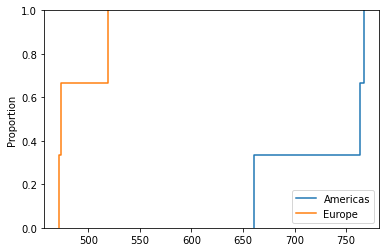

In [114]:
# эмпиричесская функция распределния вероятностей
ig, ax = plt.subplots()
sns.ecdfplot(x=table[0], ax=ax, label='Americas')
sns.ecdfplot(x=table[1], ax=ax, label='Europe')
ax.legend();